In [21]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from functions_garch import *
from scipy.stats import *
import arviz as az
import json

In [22]:
file = open("full_mcmc.pkl", "rb")
trace_full = pickle.load(file)

In [23]:
m = 10
n_mcmc, p = np.shape(trace_full['beta'])
q = np.shape(trace_full['alpha'])[1]
d = np.shape(trace_full['b'])[1]

samples = np.zeros((m,n_mcmc,p+q+d+1))
mle = np.zeros((m,p+q+d+1))
for i in range(m) :
    file = open("mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace_dc = pickle.load(file)
    samples[i,:,0:p] = trace_dc['beta']
    samples[i,:,p:(p+q)] = trace_dc['alpha']
    samples[i,:,(p+q):(p+q+d)] = trace_dc['b']
    samples[i,:,(p+q+d):(p+q+d+1)] = np.reshape(trace_dc['omega'], [n_mcmc,1])
    
    file = open("mle_chunk"+str(i+1)+".pkl", "rb")
    mle_dc = pickle.load(file)
    mle[i,0:p] = mle_dc['beta']
    mle[i,p:(p+q)] = mle_dc['alpha']
    mle[i,(p+q):(p+q+d)] = mle_dc['b']
    mle[i,(p+q+d):(p+q+d+1)] = mle_dc['omega']

In [24]:
samples_combined = double_parallel_MC(samples, mle)
dpMC_CI = np.percentile(np.reshape(samples_combined, [np.prod(np.shape(samples_combined)[0:2]),np.shape(samples_combined)[-1]]), 
                        q=[2.5,97.5], axis=0)
beta_ci_dpMC = dpMC_CI[:,0:p]
alpha_ci_dpMC = dpMC_CI[:,p:(p+q)]
b_ci_dpMC = dpMC_CI[:,(p+q):(p+q+d)]
omega_ci_dpMC = dpMC_CI[:,(p+q+d):(p+q+d+1)]

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 24420.98it/s]


In [25]:
file = open("full_mcmc.pkl", "rb")
trace = pickle.load(file)

b_ci_full = np.percentile(trace['b'],axis=0,q=[2.5,97.5])
beta_ci_full = np.percentile(trace['beta'],axis=0,q=[2.5,97.5])
alpha_ci_full = np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])
omega_ci_full = np.percentile(trace['omega'],axis=0,q=[2.5,97.5])

b_ci_dc = np.zeros((2,d))
beta_ci_dc = np.zeros((2,p))
alpha_ci_dc = np.zeros((2,q))
omega_ci_dc = np.zeros(2)
for i in range(m) :
    file = open("mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace = pickle.load(file)
    b_ci_dc += np.percentile(trace['b'],axis=0,q=[2.5,97.5])/m
    beta_ci_dc += np.percentile(trace['beta'],axis=0,q=[2.5,97.5])/m
    alpha_ci_dc += np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])/m
    omega_ci_dc += np.percentile(trace['omega'],axis=0,q=[2.5,97.5])/m

In [26]:
# add laplace approximation
def cred_ints_laplace(quantiles):
    n_q = len(quantiles)
    with open("laplace.json") as f:
        laplace = json.load(f)
    modes, hessian = np.array(laplace['mode']), np.array(laplace['hessian'])
    var_names = laplace['var_names']
    stds = np.sqrt(np.diag(np.linalg.inv(-hessian)))
    res = np.zeros((p+q+d+1, n_q))
    i = 0
    for mode, std in zip(modes, stds):
        #print(i)
        res[i,:] = norm.ppf(np.array(quantiles) / 100, loc=mode, scale=std)
        i += 1
    res = res.T
    return (res[:,:1], res[:,1:(1+p)], res[:,(1+p):(1+q+p)], res[:,(1+q+p):])

In [27]:
p, q, d
# p-> beta
# q-> alpha
# d-> b

(2, 2, 5)

In [28]:
def cred_ints_vb(quantiles):
    n_q = len(quantiles)
    with open("vb.json") as f:
        vb = json.load(f)
    res = {}
    res['b'] = np.percentile(np.array(vb['b']), axis=0, q=quantiles)
    res['beta'] = np.percentile(np.array(vb['beta']), axis=0, q=quantiles)
    res['alpha'] = np.percentile(np.array(vb['alpha']), axis=0, q=quantiles)
    res['omega'] = np.percentile(np.array(vb['omega']), axis=0, q=quantiles)
    return res['omega'], res['beta'], res['alpha'], res['b']

In [29]:
omega_ci_lap, beta_ci_lap, alpha_ci_lap, b_ci_lap = cred_ints_laplace([2.5, 97.5])
omega_ci_vb, beta_ci_vb, alpha_ci_vb, b_ci_vb = cred_ints_vb([2.5, 97.5])

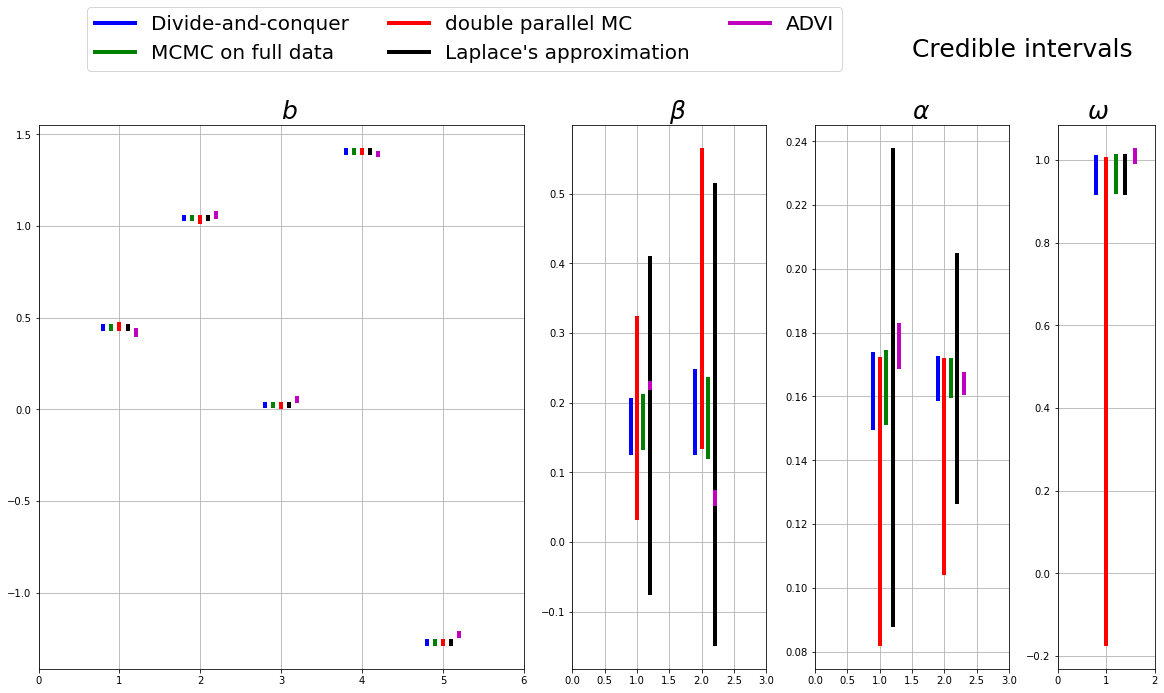

In [61]:
import matplotlib as mpl
plt.rcParams['axes.grid'] = True
f, (a0, a1, a2, a3) = plt.subplots(1, 4, gridspec_kw={'width_ratios': [d, p, q, 1]}, figsize=(20,10))

mpl.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.grid'] = True

# a0.plot(np.arange(1,d+1), b, "ro")
for i in range(d) :
    a0.plot([i+0.8,i+0.8], b_ci_dc[:,i], "b-")
    a0.plot([i+0.9,i+0.9], b_ci_full[:,i], "g-")
    a0.plot([i+1.0,i+1.0], b_ci_dpMC[:,i], "r-")
    a0.plot([i+1.1,i+1.1], b_ci_lap[:,i], "k-")
    a0.plot([i+1.2,i+1.2], b_ci_vb[:,i], "m-")
a0.axis(xmin=0,xmax=d+1)

# a1.plot(np.arange(1,p+1), beta, "ro")
for i in range(p) :
    a1.plot([i+0.9,i+0.9], beta_ci_dc[:,i], "b-")
    a1.plot([i+1.1,i+1.1], beta_ci_full[:,i], "g-")
    a1.plot([i+1,i+1], beta_ci_dpMC[:,i], "r-")
    a1.plot([i+1.2,i+1.2], beta_ci_lap[:,i], "k-")
    a1.plot([i+1.2,i+1.2], beta_ci_vb[:,i], "m-")
a1.axis(xmin=0,xmax=p+1)

# a2.plot(np.arange(1,q+1), alpha, "ro")
for i in range(q):
    a2.plot([i+0.9,i+0.9], alpha_ci_dc[:,i], "b-")
    a2.plot([i+1.1,i+1.1], alpha_ci_full[:,i], "g-")
    a2.plot([i+1,i+1], alpha_ci_dpMC[:,i], "r-")
    a2.plot([i+1.2,i+1.2], alpha_ci_lap[:,i], "k-")
    a2.plot([i+1.3,i+1.3], alpha_ci_vb[:,i], "m-")
a2.axis(xmin=0,xmax=q+1)

# a3.plot(1, omega, "ro")
a3.plot([0.8,0.8], omega_ci_dc, "b-", label="Divide-and-conquer")
a3.plot([1.2,1.2], omega_ci_full, "g-", label="MCMC on full data")
a3.plot([1,1], omega_ci_dpMC, "r-", label="double parallel MC")
a3.plot([1.4,1.4], omega_ci_lap, "k-", label="Laplace's approximation")
a3.plot([1.6,1.6], omega_ci_vb, "m-", label="ADVI")
a3.axis(xmin=0,xmax=2)

cap_height = 1.10
plt.text(x=-16.0, y=cap_height, s=r"$b$", fontsize=25)
plt.text(x=-8, y=cap_height, s=r"$\beta$", fontsize=25)
plt.text(x=-3, y=cap_height, s=r"$\alpha$", fontsize=25)
plt.text(x=0.6, y=cap_height, s=r"$\omega$", fontsize=25)
plt.text(x=-3, y=cap_height+0.15, s=r"Credible intervals", fontsize=25)
plt.legend(ncol=3, loc=(-10,1.10),  prop={'size': 20})
f.savefig('garch_CI.pdf', bbox_inches='tight', dpi=2000)

In [62]:
eff_samp_sizes = np.zeros((10, p+q+d+1))
for i in range(m) :
    file = open("mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace = pickle.load(file)
    eff_samp_sizes[i,:d] = [az.ess(col) for col in trace['b'].T]
    eff_samp_sizes[i,d:(d+p)] = [az.ess(col) for col in trace['beta'].T]
    eff_samp_sizes[i,(d+p):(p+q+d)] = [az.ess(col) for col in trace['alpha'].T]
    eff_samp_sizes[i,p+q+d] = az.ess(trace['omega'])

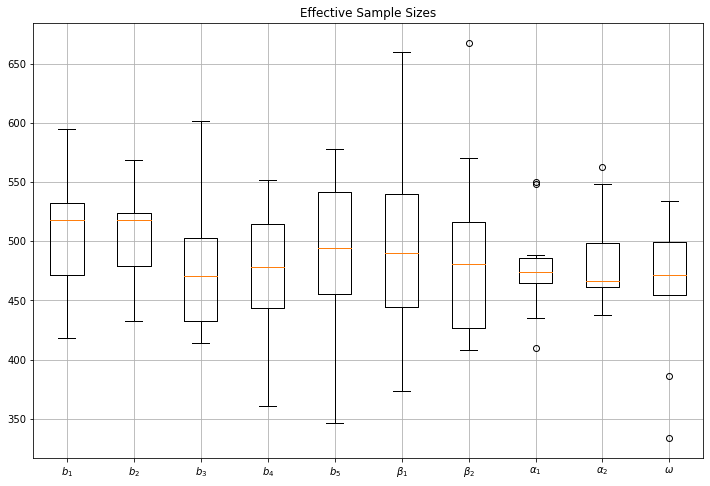

In [63]:
xlabs = [r"$b_" + str(i+1) + "$"  for i in range(d)] + [r'$\beta_' + str(i+1) + '$' for i in range(p)] 
xlabs += [r"$\alpha_" + str(i+1) + "$"  for i in range(q)]
xlabs += [r"$\omega$"]
fig = plt.figure(figsize=(12,8))
plt.boxplot(eff_samp_sizes)
plt.xticks(np.arange(1, p+q+d+2), labels=xlabs)
plt.title("Effective Sample Sizes")
fig.savefig('garch_ess.pdf', bbox_inches='tight', dpi=2000)
plt.show()